# Tree based models 

Lately, tree based models like XGBoost have beaten traditional time series algorithms in time series problems. 

Although XGBoost is a powerful algorithm, its main disadvantage is the amount of hyperparameters it has to adjust. Additionally, it will require an extensive amount of data to train properly and also a intense phase of feature engineering. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.split import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanSquaredError,
    MeanAbsolutePercentageError,
)

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.difference import Differencer
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, STATUS_FAIL, fmin, hp, tpe
from hyperopt.early_stop import no_progress_loss


from sktime.forecasting.compose import make_reduction
# filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
# Read train data
ts = pd.read_csv(
    "../data/processed_train.csv",  # data path
    index_col=[0],  # index column
    parse_dates=[0],  # parse date column
)

# Get training data
train_ts = ts.dropna()

# Assert time series dates consistency by checking all dates are monthly and recorded properly (this includes missing dates if any)
train_ts = train_ts.asfreq("MS").fillna(
    0
)  # if there are missing dates, they will be filled with 0

In [3]:
y = train_ts.copy()  # copy to avoid any changes to original data
y.index = pd.PeriodIndex(y.index, freq="M")  # required frequency from sktime

# XGBoost

Fit simple XGBoost to see potential performance against itself.

,test_MeanSquaredError,test_MeanAbsoluteError,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.697825,0.519301,0.226511,44.940622,2.416076,37,2018-01
1,0.561396,0.458272,0.202446,56.990448,3.133609,49,2019-01
2,0.559806,0.460542,0.186289,50.914959,2.146701,61,2020-01


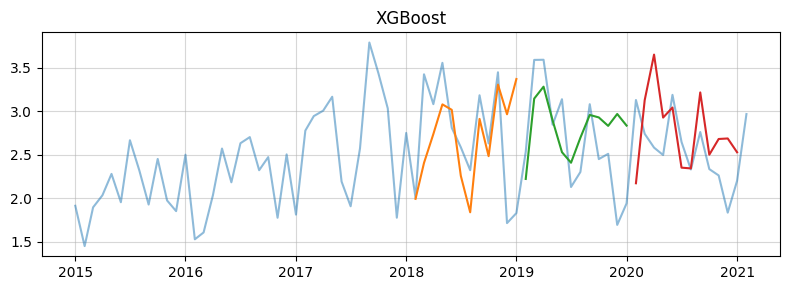

In [4]:
# Define time series cross validation)
from sktime.transformations.series.boxcox import LogTransformer

from sktime.transformations.panel.tsfresh import (
    TSFreshRelevantFeatureExtractor,
    TSFreshFeatureExtractor,
)
from sklearn.pipeline import make_pipeline


cv = ExpandingWindowSplitter(initial_window=37, step_length=12, fh=np.arange(1, 13))

params = {
    'n_estimators': 700,
    'max_depth': 8,
    'learning_rate': 0.05,
    'booster': 'gbtree',
    'tree_method':'exact',
    'n_jobs': -1,
    'random_state': 42,
    'objective': 'reg:squarederror',
    'verbosity': 0
}

regressor = make_pipeline(TSFreshFeatureExtractor(
        default_fc_parameters="comprehensive",
        show_warnings=False,
        disable_progressbar=True,), XGBRegressor(**params))

forecaster = TransformedTargetForecaster(
    [
        (
            "forecast", make_reduction(regressor, strategy="direct", scitype="time-series-regressor", window_length=12)
        )
    ]
)


results = evaluate(
    forecaster=forecaster,
    y=y,
    cv=cv,
    scoring=[
        MeanSquaredError(square_root=True),
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
    ],
)

display(results)

# Plot forecasts for each split of cv
fig = plt.figure(figsize=(8, 3))
plt.plot(train_ts, alpha=0.5)
for train, test in cv.split(y):
    model = forecaster.fit(y.iloc[train], fh=y.iloc[test].index)
    y_pred_1 = model.predict(fh=y.iloc[test].index)
    plt.plot(train_ts.iloc[test].index, y_pred_1)
plt.grid(alpha=0.5)
plt.title("XGBoost")
plt.tight_layout()
plt.show()

## XGBoost Hyperparameter tuning

Hyperopt library will be used to tune the hyperparameters of the XGBoost model, since this is more efficient than GridSearch. For the XGBoost hyperparameters to be found properly, the tuning must be split in two consecutive stages:
1. Find learning related hyperparameters (n_estimators, learning_rate, max_depth)
2. Tune regularization related hyperparameters to prevent overfitting (min_child_weight, gamma, reg_alpha, reg_lambda, max_delta_step)

In [5]:
print("[2] Hyperparameter tuning")
print("-"*100)

# TRAIN AND VAL DATA
train_data = y[:37] # UNTIL 2018
val_data = y[37:37+12] # UNTIL 2019
 

# HYPEROPT
best_hyperparams_total = {}


MAX_HYPEROPT_EVALS = 100
INT_XGB_PARAMS = ['n_estimators', 'max_depth',
                   'min_child_weight'
                   ]


# Learning related hyperparams
space_1 = {
    'n_estimators': hp.quniform('n_estimators', 300, 1000, 100), # number of trees built
    'learning_rate': hp.loguniform('learning_rate', -3, -1),
    'max_depth': hp.quniform('max_depth', 3, 12, 1), # large max_depth -> OOM 
}

# Regularization hyperparams
space_2 = {
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    # 'gamma': hp.quniform('gamma', 0, 500, 1),  # Minimum loss reduction required to make a further partition on a leaf node
    'reg_alpha' : hp.quniform('reg_alpha', 0, 2, 0.1),  # L1 regularization term on weights Used for high dimensionality (feature selection)
    #'reg_lambda': hp.quniform('reg_lambda', 0, 10, 0.1),  # L2 regularization term on weights
    # 'max_delta_step': hp.quniform('max_delta_step', 0, 10, 1),  # Maximum delta step we allow each leaf output
}


# HYPEROPT ----------------------------------------------------------------------------------------------------------------------------------------------------
def objective(params):
    """
    Objective function for hyperopt. Optimizes the model using the given hyperparameters.
    """
    params = {k: int(v) if k in INT_XGB_PARAMS else float(v) for k, v in params.items()}

    regressor = make_pipeline(TSFreshFeatureExtractor(
        default_fc_parameters="comprehensive",
        show_warnings=False,
        disable_progressbar=True,), XGBRegressor(**params, random_state=42))

    forecaster = TransformedTargetForecaster(
        [
            (
                "forecast", make_reduction(regressor, strategy="direct", scitype="time-series-regressor", window_length=12)
            )
        ]
    )

    try:
        # fit model
        model = forecaster.fit(train_data, fh=val_data.index)
        # evaluate model
        y_pred = model.predict(val_data.index)
        mse = mean_squared_error(val_data.values, y_pred.values)

        loss = mse
                
    except Exception as e:
        loss = 9999

    return {'loss': loss, 'status': STATUS_OK}
 

# 1. tune learning related hyperparams
best_learning_hyperparams = fmin(fn = objective, 
                space = space_1,
                algo = tpe.suggest,
                max_evals = MAX_HYPEROPT_EVALS,
                early_stop_fn=no_progress_loss(15), 
                rstate=np.random.default_rng(123)
                )
print(f"\t {best_learning_hyperparams}")

# 2. tune regularization hyperparams
space_2.update(best_learning_hyperparams)
best_hyperparams = fmin(fn = objective, 
                space = space_2,
                algo = tpe.suggest,
                max_evals = MAX_HYPEROPT_EVALS,
                early_stop_fn=no_progress_loss(15), 
                rstate=np.random.default_rng(123)
                )
print(f"\t {best_hyperparams}")

print("-"*100)


[2] Hyperparameter tuning
--------------------------------------------------
 23%|██▎       | 23/100 [14:53<49:52, 38.86s/trial, best loss: 0.4127885396423734]  
	 {'learning_rate': 0.36584432082580803, 'max_depth': 12.0, 'n_estimators': 800.0}
 53%|█████▎    | 53/100 [39:34<35:05, 44.79s/trial, best loss: 0.34396404928687346]  
	 {'min_child_weight': 6.0, 'reg_alpha': 0.5}
----------------------------------------------------------------------------------------------------


,test_MeanSquaredError,test_MeanAbsoluteError,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.586484,0.461957,0.186634,40.080192,4.235633,37,2018-01
1,0.554093,0.460584,0.190518,63.765792,2.145538,49,2019-01
2,0.483949,0.417946,0.160642,46.682288,1.936835,61,2020-01


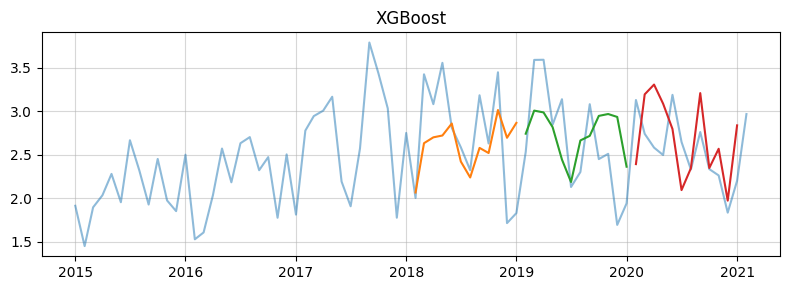

In [7]:
# RUN AGAIN WITH BEST HYPERPARAMS

cv = ExpandingWindowSplitter(initial_window=37, step_length=12, fh=np.arange(1, 13))

params = {
    'n_estimators': 800,
    'max_depth': 12,
    'learning_rate': 0.36584432082580803,
    'min_child_weight': 6,
    'reg_alpha': 0.5,
    'tree_method':'exact',
    'n_jobs': -1,
    'random_state': 42,
    'objective': 'reg:squarederror',
    'verbosity': 0
}

regressor = make_pipeline(TSFreshFeatureExtractor(
        default_fc_parameters="comprehensive",
        show_warnings=False,
        disable_progressbar=True,), XGBRegressor(**params))

forecaster = TransformedTargetForecaster(
    [
        (
            "forecast", make_reduction(regressor, strategy="direct", scitype="time-series-regressor", window_length=12)
        )
    ]
)


results = evaluate(
    forecaster=forecaster,
    y=y,
    cv=cv,
    scoring=[
        MeanSquaredError(square_root=True),
        MeanAbsoluteError(),
        MeanAbsolutePercentageError(),
    ],
)

display(results)

# Plot forecasts for each split of cv
fig = plt.figure(figsize=(8, 3))
plt.plot(train_ts, alpha=0.5)
for train, test in cv.split(y):
    model = forecaster.fit(y.iloc[train], fh=y.iloc[test].index)
    y_pred_1 = model.predict(fh=y.iloc[test].index)
    plt.plot(train_ts.iloc[test].index, y_pred_1)
plt.grid(alpha=0.5)
plt.title("XGBoost")
plt.tight_layout()
plt.show()

The metrics of the xgboost are worse than the baseline and arima, probably due to the complexity of the model and lack of complexity of the series. 

In [8]:
# Read evaluation file and merge with arima ones
eval_df = pd.read_csv(
    "../data/evaluation.csv",  # data path
    index_col=[0],  # index column
    parse_dates=[0],  # parse date column
)

results['model'] = 'xgboost'

# join with evaluation file on cutoff with concat
eval_df = pd.concat([results, eval_df], axis=0).sort_values(by=['test_MeanSquaredError'], ascending=True)

# # Save evaluation file
# eval_df.to_csv("../data/evaluation.csv")

eval_df

,test_MeanSquaredError,test_MeanAbsoluteError,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,model
1,0.415477,0.323653,0.121826,0.339348,0.029449,49,2019-01,arima
1,0.441073,0.340174,0.127364,0.002210,0.102121,49,2019-01,baseline_naive_last
2,0.455080,0.368440,0.142906,0.323295,0.016517,61,2020-01,arima
2,0.479795,0.374270,0.143973,0.003071,0.026912,61,2020-01,baseline_naive_last
2,0.483949,0.417946,0.160642,46.682288,1.936835,61,2020-01,xgboost
1,0.554093,0.460584,0.190518,63.765792,2.145538,49,2019-01,xgboost
0,0.573653,0.507329,0.201105,0.002970,0.034698,37,2018-01,baseline_naive_last
0,0.586484,0.461957,0.186634,40.080192,4.235633,37,2018-01,xgboost
0,1.174655,0.958420,0.397385,0.304826,0.029143,37,2018-01,arima
